# **Welcome to the best underwater object detection model known to date**


---
What's going on?


*   We are using a convoluted neural network to detect objects underwater
*   We are using a method called transfer learning to retrain a prebuilt model
*   At a learning rate of 0.0002, we retrained the weights of the faster_rcnn_inception_v2_coco model (taken from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md/) for our needs
*   This model was trained a total of 30k steps


---

Some pointers:


*   Please don't modify the code at all (unless it's for inputting different images/vids). If it's necessary to modify, tell Youssef first
*   Testing and training images can be found under: /content/drive/My Drive/models/research/object_detection/AQD_images
*   Vids can be found in a separate folder
*   Be sure to mount your Gdrive
*   Runtime -> Chanage runtime type -> GPU







In [ ]:
!pip install -U --pre tensorflow=="2.*"

     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 460kB 36.6MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
!pip install pycocotools

In [ ]:
%%bash
cd drive/My\ Drive/models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 14.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 2.7MB 46.3MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp36-none-any.whl size=844515 sha256=ad64fcab0067827b159e3b42885c3a223bbf44f7040e03fc88c421ed95a3d8e1
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api
ERROR: readme-renderer 26.0 has requirement Pygments>=2.5.1, but you'll have pygments 2.1.3 which is incompatible.


In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

import cv2
from google.colab.patches import cv2_imshow

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [ ]:
def load_model():

    model = tf.saved_model.load('/content/drive/My Drive/models/research/object_detection/AQD_inference_graph_30k/saved_model')
    model = model.signatures['serving_default']

    return model

In [ ]:
PATH_TO_LABELS = '/content/drive/My Drive/models/research/object_detection/AQD_training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
detection_model = load_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def run_inference_for_single_image(model, image_np):
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image_np)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

  # Visualize detection
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=3,
      min_score_thresh = 0.8
      )

  return output_dict

In [ ]:
def CheckOverlap(l1, r1, l2, r2): 
  """
  Check if two rectangles overlap
  l1/r1: tf bounding box
  l2/r2: custom rectangle
  """ 
  if (l1[0] >= l2[0] and l1[0] <= r2[0]) or (r1[0] >= l2[0] and r1[0] <= r2[0]): 
    return True

  return False

In [ ]:
def isBottom(l1, r1, l2, r2):
  """
  Check if tf bounding box ends up in custom bottom box.
  l1/r1: tf bounding box
  l2/r2: custom rectangle
  """
  if(l1[1] >= l2[1]):
    return True

  return False

In [ ]:
def isObstacle(class_id):
  """
  Check if label id is considered an obstacle.
  1: Aquatic Plant
  2: Hard Substrate
  3: Fish
  As per labelmap.pbtxt
  """
  if(class_id==1 or class_id==2):
    return True
  return False

The below is for single image detection

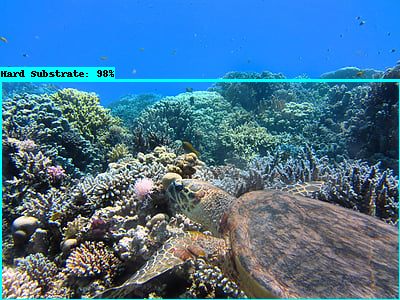

Hard Substrate
stop


In [ ]:
frame = np.array(Image.open('/content/turtle-sea-underwater-coral-thumb.jpg'))
rows, cols = frame.shape[:2]
frame_width = frame.shape[1]
frame_height = frame.shape[0]

# 1: top left
# 2: bottom right

rec_left1 = (int(cols*0.0), int(rows*0.0))
rec_left2 = (int(cols*0.33), int(rows*0.6))

rec_mid1 = (rec_left2[0], rec_left1[1])
rec_mid2 = (int(cols*0.66), rec_left2[1])

rec_right1 = (rec_mid2[0], rec_mid1[1])
rec_right2 = (int(cols*1.0), rec_mid2[1])

rec_bottom1 = (int(cols*0.0), int(rows*0.6))
rec_bottom2 = (int(cols*1.0), int(rows*1.0))



output_dict = run_inference_for_single_image(detection_model,frame)

# draw rectangles AFTER inference to avoid detection issues
# cv2.rectangle(frame, rec_left1, rec_left2, color=(255, 0, 0), thickness=2)
# cv2.rectangle(frame, rec_mid1, rec_mid2, color=(255, 0, 0), thickness=2)
# cv2.rectangle(frame, rec_right1, rec_right2, color=(255, 0, 0), thickness=2)
# cv2.rectangle(frame, rec_bottom1, rec_bottom2, color=(255, 0, 0), thickness=2)

display(Image.fromarray(frame)) # actually show the inference

boxes = output_dict['detection_boxes'] # for box coordinates

min_thresehold = 0.8  # must have a confidence score > 80%

for i in range(len(output_dict['detection_scores'])):
  if(output_dict['detection_scores'][i] < min_thresehold): # this list is sorted from max -> min
    break
  
  class_id = category_index[output_dict['detection_classes'][i]]
  print(class_id.get('name'))
  # print(category_index[output_dict['detection_classes'][i]].get('name'))
  
  if not isObstacle(class_id.get('id')):
    continue

  ymin = (int(boxes[i,0]*frame_height))
  xmin = (int(boxes[i,1]*frame_width))
  ymax = (int(boxes[i,2]*frame_height))
  xmax = (int(boxes[i,3]*frame_width))

  # for readability dont simplify code
  top_left = (xmin, ymin)  # remember, this is how tensorflow calculates it
  bottom_right = (xmax, ymax) 

  bottom_check = isBottom(top_left, bottom_right, rec_bottom1, rec_bottom2)
  if(bottom_check):
    print("move up")
    continue

  left_check = CheckOverlap(top_left, bottom_right, rec_left1, rec_left2)
  mid_check = CheckOverlap(top_left, bottom_right, rec_mid1, rec_mid2)
  right_check = CheckOverlap(top_left, bottom_right, rec_right1, rec_right2)

  # navigation logic

  if((left_check and mid_check and right_check) or (left_check and right_check)):
    print("stop")
    continue
  
  if(left_check):
    print("move right")
    continue

  if(right_check):
    print("move left")
    continue
  
  if(mid_check):
    print("move left") # can be right too
    continue
  
  print("keep going")




The below is for video detection frame by frame. I suggest running this for like 20 seconds (or whatever works for you) then doing Runtime -> Interruput execution to avoid browser memory issues (give it a few seconds to actually stop running).

In [ ]:
vid = cv2.VideoCapture("/content/1.mp4") 
while vid.isOpened():
  ret, frame = vid.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # no idea why opencv does BGR instead of RGB 

  rows, cols = frame.shape[:2]
  frame_width = frame.shape[1]
  frame_height = frame.shape[0]

  # 1: top left
  # 2: bottom right

  rec_left1 = (int(cols*0.0), int(rows*0.0))
  rec_left2 = (int(cols*0.33), int(rows*0.6))

  rec_mid1 = (rec_left2[0], rec_left1[1])
  rec_mid2 = (int(cols*0.66), rec_left2[1])

  rec_right1 = (rec_mid2[0], rec_mid1[1])
  rec_right2 = (int(cols*1.0), rec_mid2[1])

  rec_bottom1 = (int(cols*0.0), int(rows*0.6))
  rec_bottom2 = (int(cols*1.0), int(rows*1.0))


  output_dict = run_inference_for_single_image(detection_model, frame)

  # draw rectangles AFTER inference to avoid detection issues
  cv2.rectangle(frame, rec_left1, rec_left2, color=(255, 0, 0), thickness=2) 
  cv2.rectangle(frame, rec_mid1, rec_mid2, color=(255, 0, 0), thickness=2)
  cv2.rectangle(frame, rec_right1, rec_right2, color=(255, 0, 0), thickness=2)
  cv2.rectangle(frame, rec_bottom1, rec_bottom2, color=(255, 0, 0), thickness=2)  

  display(Image.fromarray(frame)) # actually show the inference

  boxes = output_dict['detection_boxes'] # for box coordinates

  min_thresehold = 0.8  # must have a confidence score > 80%

  for i in range(len(output_dict['detection_scores'])):
    if(output_dict['detection_scores'][i] < min_thresehold): # this list is sorted from max -> min
      break

    class_id = category_index[output_dict['detection_classes'][i]]
    print(class_id.get('name'))
    # print(category_index[output_dict['detection_classes'][i]].get('name'))
  
    if not isObstacle(class_id.get('id')):
      print("here")
      continue

    ymin = (int(boxes[i,0]*frame_height))
    xmin = (int(boxes[i,1]*frame_width))
    ymax = (int(boxes[i,2]*frame_height))
    xmax = (int(boxes[i,3]*frame_width))

    # for readability dont simplify code
    top_left = (xmin, ymin)  # remember, this is how tensorflow calculates it
    bottom_right = (xmax, ymax) 

    bottom_check = isBottom(top_left, bottom_right, rec_bottom1, rec_bottom2)
    if(bottom_check):
      print("move up")
      continue

    left_check = CheckOverlap(top_left, bottom_right, rec_left1, rec_left2)
    mid_check = CheckOverlap(top_left, bottom_right, rec_mid1, rec_mid2)
    right_check = CheckOverlap(top_left, bottom_right, rec_right1, rec_right2)

    # navigation logic

    if((left_check and mid_check and right_check) or (left_check and right_check)):
      print("stop")
      continue
    
    if(left_check):
      print("move right")
      continue

    if(right_check):
      print("move left")
      continue
    
    if(mid_check):
      print("move left") # can be right too
      continue
    
    print("keep going")
    

cv2.VideoCapture.release(vid)
